In [1]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = [16, 8]
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
# All variables we care about
FcolumnNames1999_2007 = ['releaseNum', 'familyID', 'composition', 'headCount', 'ageHead', 'maritalStatus', 'own', 
                         'employmentStatus', 'liquidWealth', 'race', 'industry','incomeHead', "incomeWife", 
               'foodCost', 'houseCost', 'transCost', 'educationCost', 'childCost', 'healthCost', 'education', 
               'participation', 'investmentAmount', 'annuityIRA', 'wealthWithoutHomeEquity', "wealthWithHomeEquity"]

FcolumnNames2009_2017 = ['releaseNum', 'familyID', 'composition', 'headCount', 'ageHead', 'maritalStatus', 'own', 
                         'employmentStatus', 'liquidWealth', 'race', 'industry' ,'incomeHead', 'incomeWife', 
               'participation', 'investmentAmount', 'annuityIRA', 'wealthWithoutHomeEquity', 'wealthWithHomeEquity',
               'foodCost', 'houseCost', 'transCost', 'educationCost', 'childCost', 'healthCost', 'education']

FcolumnNames2019 = ['releaseNum', 'familyID', 'composition', 'headCount', 'ageHead', 'maritalStatus', 'own', 
                         'employmentStatus', 'liquidWealth_bank', 'liquidWealth_bond', 'race', 'industry' ,'incomeHead', 'incomeWife', 
               'participation', 'investmentAmount', 'annuityIRA', 'wealthWithoutHomeEquity', 'wealthWithHomeEquity',
               'foodCost', 'houseCost', 'transCost', 'educationCost', 'childCost', 'healthCost', 'education']

# The timeline we care about
years = [1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019]

In [3]:
def Fcompile_data_with_features(features, years = years):
    df = pd.DataFrame()
    # Loading the data through years
    for year in years:
        df_sub = pd.read_csv(str(year) + ".csv")
        if year >= 1999 and year <= 2007:
            df_sub.columns = FcolumnNames1999_2007
        elif year >= 2009 and year <= 2017:
            df_sub.columns = FcolumnNames2009_2017
        else:
            # In the year 2019, the liquid wealth equals to liquidWealth in cash and liquid bond
            df_sub.columns = FcolumnNames2019
            df_sub["liquidWealth"] = df_sub['liquidWealth_bank'] + df_sub['liquidWealth_bond']
        df_sub['year'] = year
        df = pd.concat([df, df_sub[['familyID','year'] + features]])
    df = df.reset_index(drop = True)
    return df

# The function is used to drop the values we do not like in the dataFrame, 
# the input "features" and "values" are both list
def drop_values(features, values, df): 
    for feature in features:
        for value in values:
            df = df[df[feature] != value]
    df = df.reset_index(drop = True)
    return df

In [4]:
# prepare the combined dataset and set up dummy variables for qualitative data
df = Fcompile_data_with_features(['composition', 'headCount', 'ageHead', 'maritalStatus', 'own',
                                  'employmentStatus', 'liquidWealth', 'race', 'industry','incomeHead', 'incomeWife', 
                                  'foodCost', 'houseCost', 'transCost', 'educationCost', 'childCost', 'healthCost', 'education', 
                                  'participation', 'investmentAmount', 'annuityIRA', 'wealthWithoutHomeEquity', 'wealthWithHomeEquity'], years)

In [5]:
# data clean, drop NA/DK values
df = drop_values(["ageHead"],[999], df)
df = drop_values(["maritalStatus"],[8,9], df)
df = drop_values(["own"],[8,9], df)
df = drop_values(["employmentStatus"],[0,22,8,98, 99], df)
df = drop_values(["liquidWealth"],[999999998,999999999,-400], df)
df = drop_values(["race"],[0,8,9], df)
df = drop_values(["industry"],[999,9999,0], df)
df = drop_values(["education"],[99,0], df)
# calculate the aggregate variables 
df["totalExpense"] = df[['foodCost', 'houseCost', 'transCost', 
                                      'educationCost', 'childCost', 'healthCost']].sum(axis = 1)
df["laborIncome"] = df["incomeHead"] + df["incomeWife"]
df["costPerPerson"] = df["totalExpense"]/df["headCount"]
df["HomeEquity"] = df["wealthWithHomeEquity"] - df["wealthWithoutHomeEquity"]

In [6]:
maritalStatus = ["Married", "neverMarried", "Widowed", "Divorced", "Separated"]
employmentStatus = ["Working", "temporalLeave", "unemployed", "retired", "disabled", "keepHouse", "student", "other"]
race = ["White", "Black","AmericanIndian","Asian","Latino","otherBW","otherRace"]
# Education
# < 8th grade: middle school
# >= 8 and < 12: high scho0l
# >=12 and < 15: college
# >= 15 post graduate
education = ["middleSchool", "highSchool", "college", "postGraduate"]
# Industry
# < 400 manufacturing
# >= 400 and < 500 publicUtility
# >= 500 and < 680 retail 
# >= 680 and < 720 finance
# >= 720 and < 900 service
# >= 900 otherIndustry
industry = ["finance", "noneFinance"]
ownership = ["owner", "renter"]

data = []
for i in tqdm(range(len(df))):
    dataCollect = []
    # marital status
    dataCollect.append(maritalStatus[int(df.iloc[i]["maritalStatus"]-1)])
    # employment
    dataCollect.append(employmentStatus[int(df.iloc[i]["employmentStatus"]-1)])
    # race
    dataCollect.append(race[int(df.iloc[i]["race"] - 1)])
    # Education variable 
    if df.iloc[i]["education"] < 8:
        dataCollect.append(education[0])
    elif df.iloc[i]["education"] >= 8 and df.iloc[i]["education"] < 12:
        dataCollect.append(education[1])
    elif df.iloc[i]["education"] >= 12 and df.iloc[i]["education"] < 15:
        dataCollect.append(education[2])
    else:
        dataCollect.append(education[3])
    # industry variable 
    if df.iloc[i]["year"] in [1999, 2001]:
        if df.iloc[i]["industry"] >= 707 and df.iloc[i]["industry"] <= 718:
            dataCollect.append(industry[0])
        else:
            dataCollect.append(industry[1])
    elif df.iloc[i]["year"] in [2003,2005,2007,2009,2011,2013,2015,2015]:
        if df.iloc[i]["industry"] >= 687 and df.iloc[i]["industry"] <= 699:
            dataCollect.append(industry[0])
        else:
            dataCollect.append(industry[1])        
    else:
        if df.iloc[i]["industry"] >= 6870 and df.iloc[i]["industry"] <= 6990:
            dataCollect.append(industry[0])
        else:
            dataCollect.append(industry[1])
    # ownership status 
    if df.iloc[i]["own"] == 1:
        dataCollect.append(ownership[0])
    else:
        dataCollect.append(ownership[1])
    data.append(dataCollect)
# Categorical dataFrame
df_cat = pd.DataFrame(data, columns = ["maritalStatus", "employmentStatus", "race", "education", "industry", "ownership"])

Fdf = pd.concat([df[["familyID", "year",'composition', 'headCount', 'ageHead', 'liquidWealth', 'laborIncome', 
                     "costPerPerson","totalExpense", 'participation', 'investmentAmount', 'annuityIRA', 
                                 'wealthWithoutHomeEquity', "wealthWithHomeEquity", "HomeEquity"]], 
                          df_cat[["maritalStatus", "employmentStatus", "education","race", "industry", "ownership"]]], axis=1)

100%|██████████| 69692/69692 [02:24<00:00, 483.87it/s]


In [7]:
# Adjust for inflation, all values are in thousand dollor
years = [1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019]
values_at2020 = np.array([1.55, 1.46, 1.40, 1.32, 1.24, 1.20, 1.15, 1.11, 1.09, 1.05, 1.01])
values_at2005 = values_at2020/1.32
quantVariables = ['annuityIRA', 'investmentAmount', 'liquidWealth', 'laborIncome', 'costPerPerson',
                 'totalExpense', 'wealthWithoutHomeEquity', 'wealthWithHomeEquity', "HomeEquity"]
for i in tqdm(range(len(Fdf))):
    for variable in quantVariables:
        Fdf.loc[i, variable] = round(Fdf.loc[i, variable] * values_at2005[years.index(Fdf.loc[i,"year"])] / 1000, 2)
Fdf.head()

100%|██████████| 69692/69692 [05:30<00:00, 210.58it/s]


,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,participation,...,annuityIRA,wealthWithoutHomeEquity,wealthWithHomeEquity,HomeEquity,maritalStatus,employmentStatus,education,race,industry,ownership
0,3,1999,2,1,76,2.35,0.00,7.30,7.30,0,...,0.00,36.99,107.44,70.45,Widowed,retired,middleSchool,White,noneFinance,owner
1,2,1999,0,4,47,0.00,26.14,4.17,16.68,1,...,0.00,23.48,30.53,7.05,Married,Working,highSchool,White,noneFinance,owner
2,6129,1999,3,1,45,8.81,0.00,16.70,16.70,1,...,19.96,447.97,485.55,37.58,Divorced,Working,college,White,finance,owner
3,6944,1999,0,2,39,14.09,35.23,10.29,20.58,0,...,0.00,31.70,49.32,17.61,Divorced,Working,college,White,noneFinance,owner
4,3818,1999,4,4,34,0.00,48.85,4.45,17.80,0,...,0.00,14.09,23.48,9.39,Married,Working,highSchool,White,noneFinance,owner


In [8]:
# drop the outliers 
for var in quantVariables:
    Fdf = Fdf[Fdf[var] < Fdf[var].quantile(0.999)]
Fdf = Fdf[(Fdf["ageHead"] >= 20) & (Fdf["ageHead"] <= 80)]
Fdf.head()
Fdf.shape

(66898, 21)

### Group population into 4 type of agents

In [9]:
lowSkill = ["middleSchool", "highSchool"]
highSkill = ["college", "postGraduate"]
highFinance = Fdf[(Fdf["education"].isin(highSkill)) & (Fdf["industry"] == "finance")]
lowFinance = Fdf[(Fdf["education"].isin(lowSkill)) & (Fdf["industry"] == "finance")]
highNoneFinance = Fdf[(Fdf["education"].isin(highSkill)) & (Fdf["industry"] == "noneFinance")]
lowNoneFinance = Fdf[(Fdf["education"].isin(lowSkill)) & (Fdf["industry"] == "noneFinance")]

In [10]:
Fdf["skillLevel"] = "High"
Fdf.loc[Fdf["education"].isin(lowSkill), "skillLevel"] = "Low"
Fdf["financeExperience"] = "No"
Fdf.loc[Fdf["industry"] == "finance", "financeExperience"] = "Yes"
Fdf["ageGroup"] = "20"
Fdf["decadeGroup"] = "90's"
for i in range(2,10, 2):
    Fdf.loc[Fdf["ageHead"] > i*10, "ageGroup"] = str(i*10)
for year in range(1990,2020,10):
    Fdf.loc[Fdf["year"] > year, "decadeGroup"] = str(year) + "s"

In [11]:
Fdf.loc[(Fdf["employmentStatus"] != "Working")&(Fdf["employmentStatus"] != "retired"), "employmentStatus"] = "unemployed"
Fdf.loc[Fdf["employmentStatus"]=="Working", "employmentStatus"] = "employed"

In [12]:
Fdf.loc[Fdf["ageGroup"]== "20", "ageGroup"] = "20-40"
Fdf.loc[Fdf["ageGroup"]== "40", "ageGroup"] = "40-60"
Fdf.loc[Fdf["ageGroup"]== "60", "ageGroup"] = "60-80"

In [13]:
Fdf.head()

,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,participation,...,maritalStatus,employmentStatus,education,race,industry,ownership,skillLevel,financeExperience,ageGroup,decadeGroup
0,3,1999,2,1,76,2.35,0.00,7.30,7.30,0,...,Widowed,retired,middleSchool,White,noneFinance,owner,Low,No,60-80,1990s
1,2,1999,0,4,47,0.00,26.14,4.17,16.68,1,...,Married,employed,highSchool,White,noneFinance,owner,Low,No,40-60,1990s
2,6129,1999,3,1,45,8.81,0.00,16.70,16.70,1,...,Divorced,employed,college,White,finance,owner,High,Yes,40-60,1990s
3,6944,1999,0,2,39,14.09,35.23,10.29,20.58,0,...,Divorced,employed,college,White,noneFinance,owner,High,No,20-40,1990s
4,3818,1999,4,4,34,0.00,48.85,4.45,17.80,0,...,Married,employed,highSchool,White,noneFinance,owner,Low,No,20-40,1990s


In [14]:
Fdf.tail()

,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,participation,...,maritalStatus,employmentStatus,education,race,industry,ownership,skillLevel,financeExperience,ageGroup,decadeGroup
69687,2534,2019,1,4,39,0.00,9.18,4.27,17.08,0,...,neverMarried,unemployed,college,Black,noneFinance,renter,High,No,20-40,2010s
69688,2162,2019,0,1,27,0.00,3.64,11.40,11.40,0,...,neverMarried,employed,college,Black,noneFinance,renter,High,No,20-40,2010s
69689,9011,2019,1,1,59,0.38,19.13,23.71,23.71,0,...,Divorced,employed,college,Black,noneFinance,renter,High,No,40-60,2010s
69690,9317,2019,8,2,61,0.00,0.00,3.91,7.83,0,...,Divorced,unemployed,college,Black,finance,renter,High,Yes,60-80,2010s
69691,3682,2019,0,4,39,6.12,112.17,11.42,45.67,0,...,Married,employed,college,Black,noneFinance,owner,High,No,20-40,2010s


In [15]:
Fdf[(Fdf["ownership"] == "renter") & (Fdf["HomeEquity"] != 0)]

,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,participation,...,maritalStatus,employmentStatus,education,race,industry,ownership,skillLevel,financeExperience,ageGroup,decadeGroup
1094,862,1999,0,1,24,1.17,7.75,20.06,20.06,0,...,neverMarried,employed,college,White,noneFinance,renter,High,No,20-40,1990s
23485,6067,2007,1,2,38,0.00,1.88,8.82,17.64,0,...,Divorced,unemployed,college,White,noneFinance,renter,High,No,20-40,2000s
24066,7122,2007,0,3,54,1.88,49.22,13.75,41.26,0,...,Married,employed,postGraduate,White,noneFinance,renter,High,No,40-60,2000s
24432,4879,2007,0,1,48,70.45,0.00,43.37,43.37,0,...,Divorced,employed,postGraduate,White,noneFinance,renter,High,No,40-60,2000s
25032,4503,2007,0,1,63,232.97,17.33,32.20,32.20,1,...,Divorced,employed,college,White,noneFinance,renter,High,No,60-80,2000s


In [16]:
Fdf["stockInvestmentRatio"] = Fdf.investmentAmount/Fdf.wealthWithoutHomeEquity
Fdf.loc[-((Fdf["stockInvestmentRatio"] >= 0)&(Fdf["stockInvestmentRatio"] <= 1)), "stockInvestmentRatio"] = 0

In [17]:
# plt.title("Mean Total Wealth Level Empirical Value vs Model Value")
# plt.plot(range(20,81), np.load("modelPoorHigh.npy"), label = "HighSkilled_model")
# plt.plot(range(20,81), np.load("modelRichLow.npy"), label = "LowSkilled_model")
# plt.plot(range(20,81), Fdf[Fdf["skillLevel"] == "High"].groupby("ageHead")["wealthWithHomeEquity"].mean().values, label = "HighSkilled_empirical")
# plt.plot(range(20,81), Fdf[Fdf["skillLevel"] == "Low"].groupby("ageHead")["wealthWithHomeEquity"].mean().values, label = "LowSkilled_empirical")
# plt.legend()
# savefig('EmpiricalVsModel.jpg')

In [18]:
Fdf.to_csv("familyData.csv")

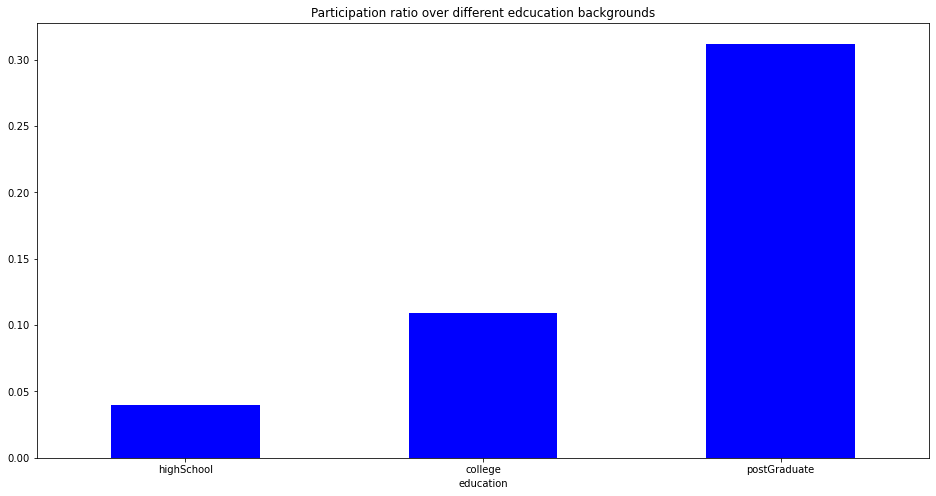

In [19]:
plt.title("Participation ratio over different edcucation backgrounds")
Fdf.loc[Fdf["education"]=="middleSchool", "education"] = "highSchool"
Fdf.groupby("education").participation.mean().reindex(["highSchool", "college", "postGraduate"]).plot.bar(color = "blue",rot=0)
savefig('educationParticipation.jpg')

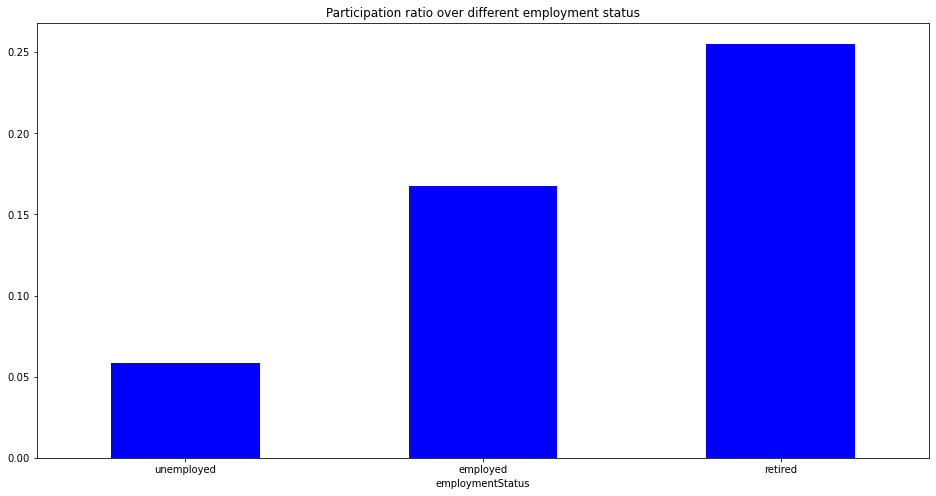

In [20]:
Fdf.loc[Fdf["employmentStatus"]=="Working", "employmentStatus"] = "employed"
plt.title("Participation ratio over different employment status")
Fdf.groupby("employmentStatus").participation.mean().reindex(["unemployed", "employed", "retired"]).plot.bar(color = "blue",rot=0)
savefig('employmentParticipation.jpg')

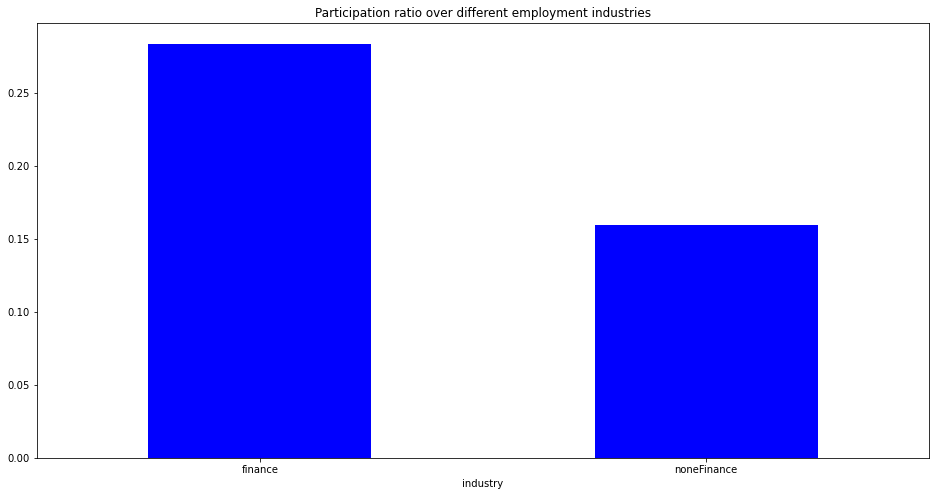

In [21]:
plt.title("Participation ratio over different employment industries")
Fdf.groupby("industry").participation.mean().plot.bar(color = "blue",rot=0)
savefig('industryParticipation.jpg')

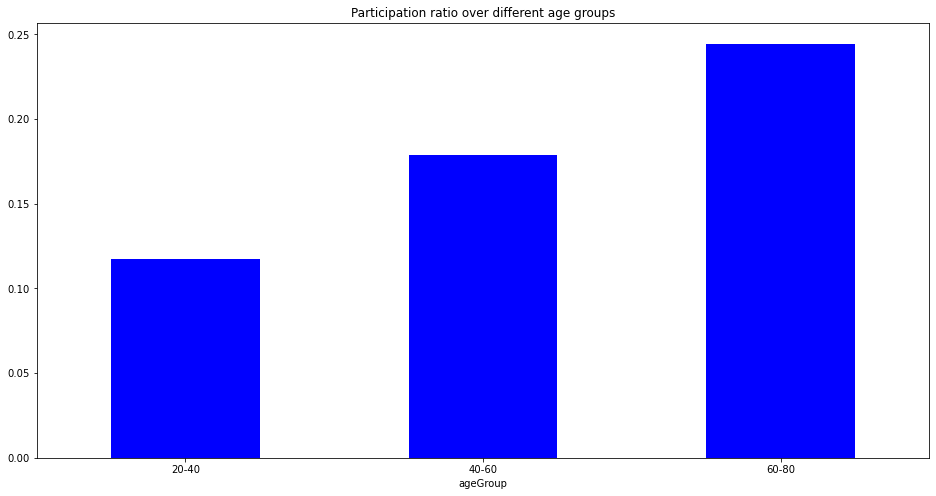

In [22]:
plt.title("Participation ratio over different age groups")
Fdf.groupby("ageGroup").participation.mean().plot.bar(color = "blue",rot=0)
savefig('ageParticipation.jpg')

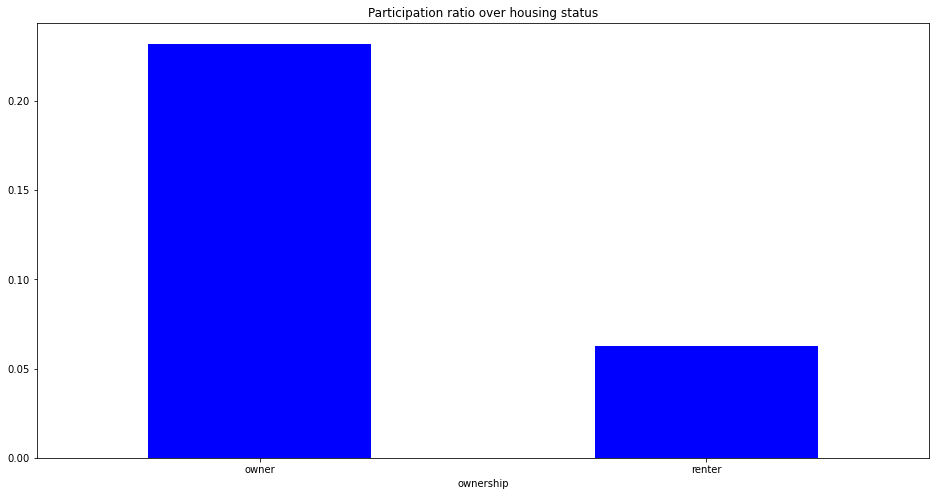

In [23]:
plt.title("Participation ratio over housing status")
Fdf.groupby("ownership").participation.mean().plot.bar(color = "blue",rot=0)
savefig('ownership.jpg')

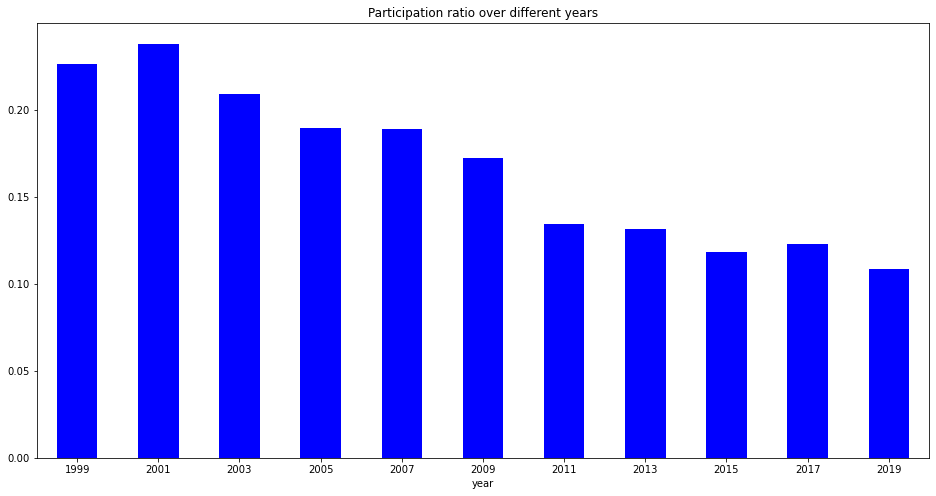

In [24]:
plt.title("Participation ratio over different years")
Fdf.groupby("year").participation.mean().plot.bar(color = "blue",rot=0)
savefig('year.jpg')

<AxesSubplot:xlabel='ageHead'>

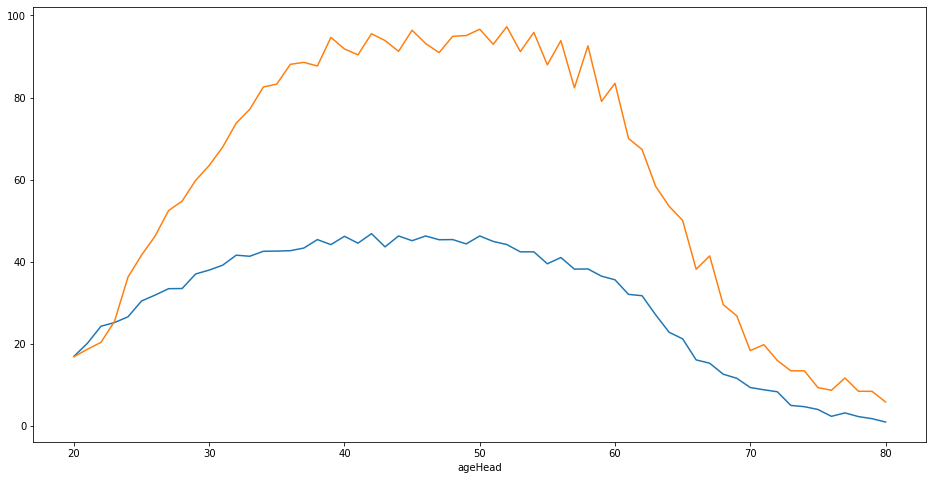

In [25]:
Fdf[(Fdf.education == 'highSchool')|(Fdf.education == 'college')].groupby("ageHead")['laborIncome'].mean().plot(label = "highSchool")
Fdf[Fdf.education == 'postGraduate'].groupby("ageHead")['laborIncome'].mean().plot(label = "postGraduate")

In [57]:
from scipy.signal import savgol_filter
lowIncome = Fdf[(Fdf.education == 'highSchool')|(Fdf.education == 'college')].groupby("ageHead")['laborIncome'].mean().values
highIncome = Fdf[Fdf.education == 'postGraduate'].groupby("ageHead")['laborIncome'].mean().values
highIncomeSmooth = savgol_filter(highIncome,window_length=9,polyorder=1)
lowIncomeSmooth = savgol_filter(lowIncome,window_length=9,polyorder=1)
ages = list(range(20,81))

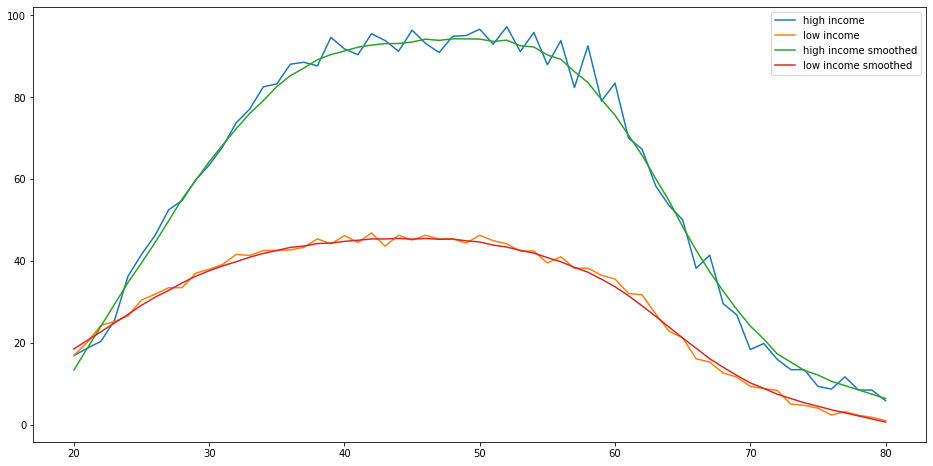

In [58]:
plt.plot(ages, highIncome, label = "high income")
plt.plot(ages, lowIncome, label = "low income")
plt.plot(ages, highIncomeSmooth, label = "high income smoothed")
plt.plot(ages, lowIncomeSmooth, label = "low income smoothed")
plt.legend()

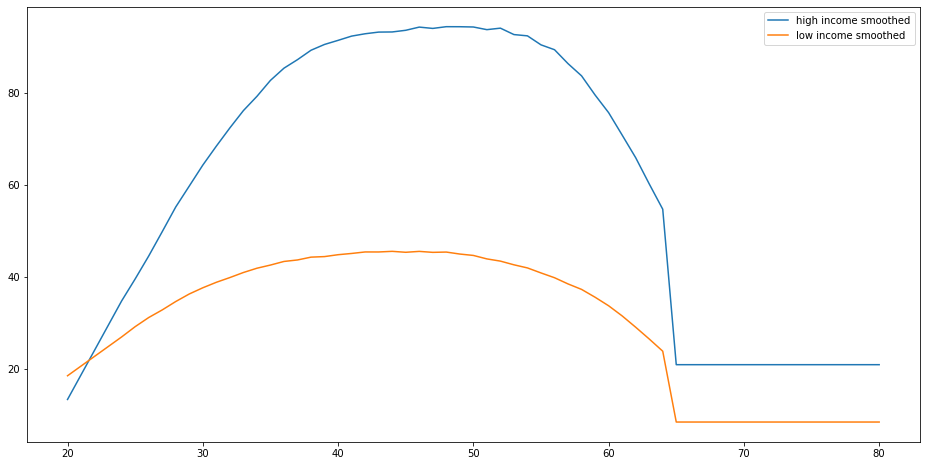

In [59]:
highIncomeSmooth[45:] = np.mean(highIncomeSmooth[45:])
lowIncomeSmooth[45:] = np.mean(lowIncomeSmooth[45:])
plt.plot(ages, highIncomeSmooth, label = "high income smoothed")
plt.plot(ages, lowIncomeSmooth, label = "low income smoothed")
plt.legend()

In [60]:
highIncomeSmooth

array([13.37849579, 18.72595173, 24.07340767, 29.42086361, 34.76831955,
       39.54163551, 44.51306305, 49.79998486, 55.164864  , 59.70479586,
       64.25238847, 68.36753109, 72.32427712, 76.07879845, 79.17340348,
       82.64031977, 85.29410514, 87.14237353, 89.18661906, 90.44546828,
       91.33075851, 92.25294797, 92.76311693, 93.12507862, 93.15385616,
       93.51619373, 94.20868926, 93.92360988, 94.29848755, 94.2909543 ,
       94.23216993, 93.65469847, 93.98051629, 92.58719735, 92.30867529,
       90.3566648 , 89.30021911, 86.27355646, 83.62504444, 79.46396248,
       75.63723767, 70.77055698, 65.86174001, 60.17673265, 54.67652659,
       20.92775299, 20.92775299, 20.92775299, 20.92775299, 20.92775299,
       20.92775299, 20.92775299, 20.92775299, 20.92775299, 20.92775299,
       20.92775299, 20.92775299, 20.92775299, 20.92775299, 20.92775299,
       20.92775299])

In [61]:
lowIncomeSmooth

array([18.52450172, 20.63137728, 22.73825285, 24.84512842, 26.95200399,
       29.18132081, 31.16179354, 32.8150436 , 34.63922158, 36.27658238,
       37.62113776, 38.81209043, 39.84020501, 40.93563765, 41.86623916,
       42.55475938, 43.33589551, 43.66047472, 44.27228605, 44.39225695,
       44.80173256, 45.07201521, 45.39861648, 45.39457498, 45.53156148,
       45.32595159, 45.52129646, 45.31114864, 45.373943  , 44.94413169,
       44.64304047, 43.89029198, 43.40944453, 42.60894212, 41.93145044,
       40.84403453, 39.80539228, 38.45687591, 37.26967232, 35.56824611,
       33.71579233, 31.51489444, 29.05899955, 26.50777094, 23.85424754,
        8.4784841 ,  8.4784841 ,  8.4784841 ,  8.4784841 ,  8.4784841 ,
        8.4784841 ,  8.4784841 ,  8.4784841 ,  8.4784841 ,  8.4784841 ,
        8.4784841 ,  8.4784841 ,  8.4784841 ,  8.4784841 ,  8.4784841 ,
        8.4784841 ])

In [65]:
# np.save("../shutDownRetirement/constant/highIncomeDetermined", highIncomeSmooth)
# np.save("../shutDownRetirement/constant/lowIncomeDetermined", lowIncomeSmooth)

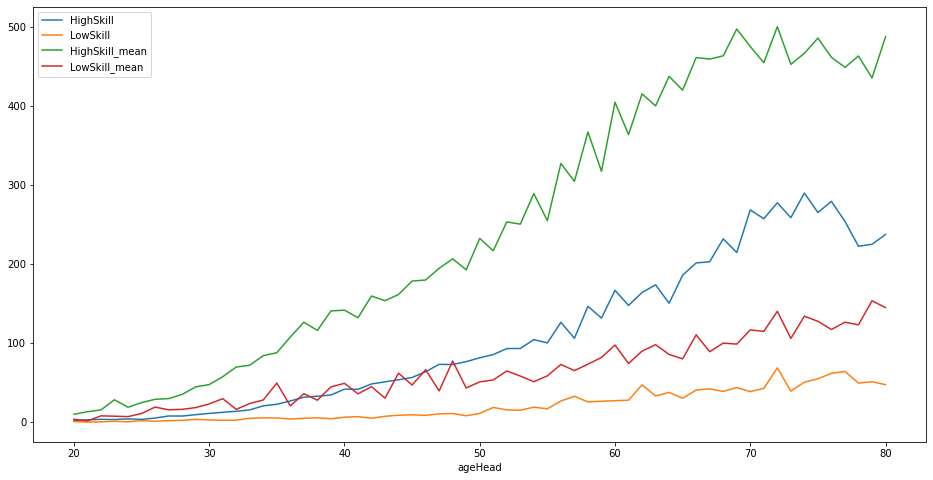

In [264]:
Fdf[Fdf.skillLevel == 'High'].groupby("ageHead")['wealthWithHomeEquity'].median().plot(label = "HighSkill")
Fdf[Fdf.skillLevel == 'Low'].groupby("ageHead")['wealthWithHomeEquity'].median().plot(label = "LowSkill")
Fdf[Fdf.skillLevel == 'High'].groupby("ageHead")['wealthWithHomeEquity'].mean().plot(label = "HighSkill_mean")
Fdf[Fdf.skillLevel == 'Low'].groupby("ageHead")['wealthWithHomeEquity'].mean().plot(label = "LowSkill_mean")
plt.legend()

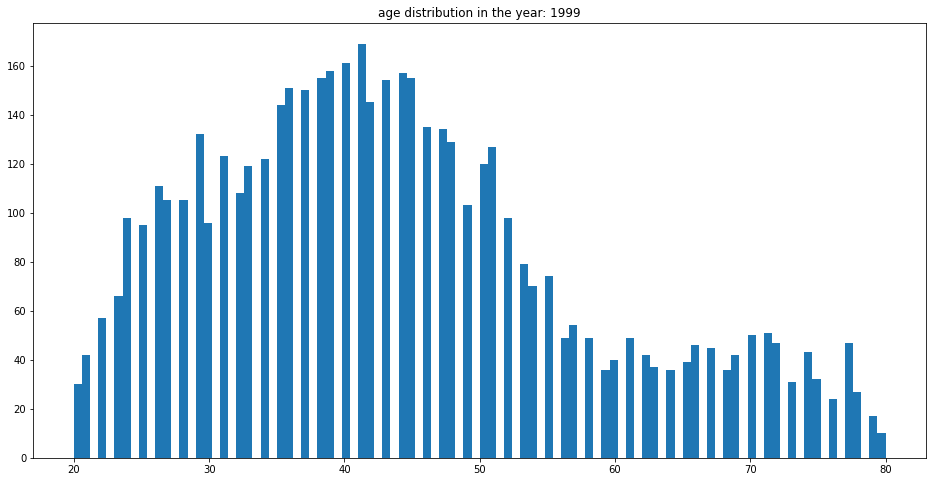

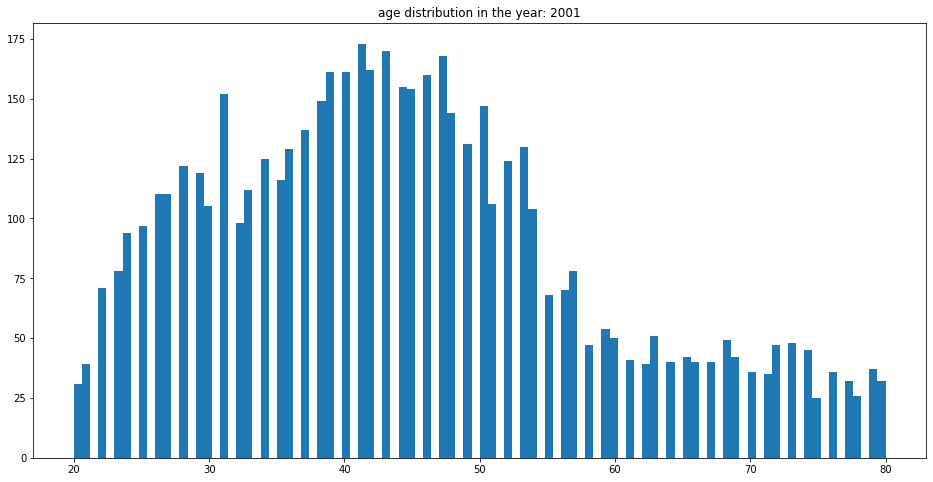

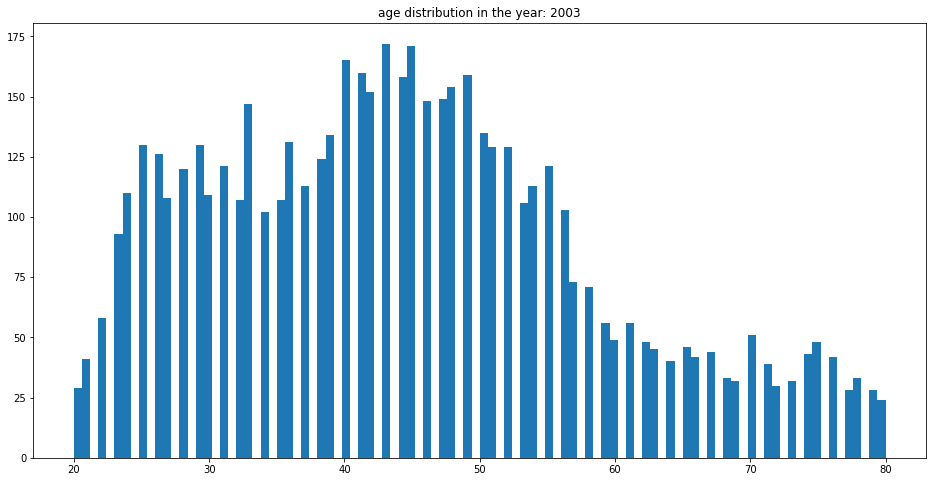

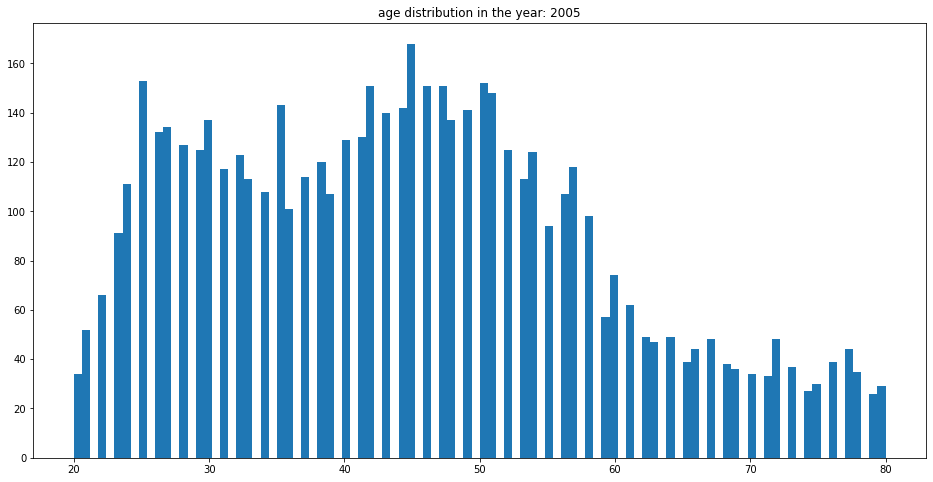

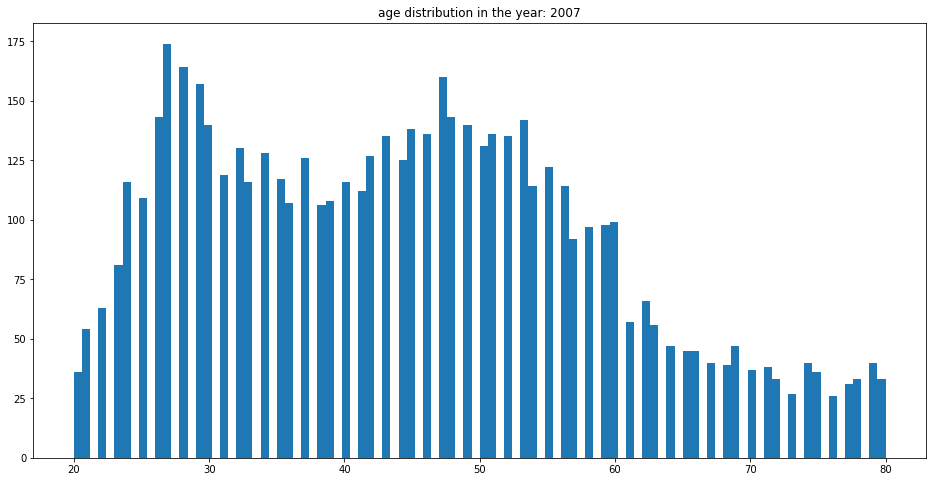

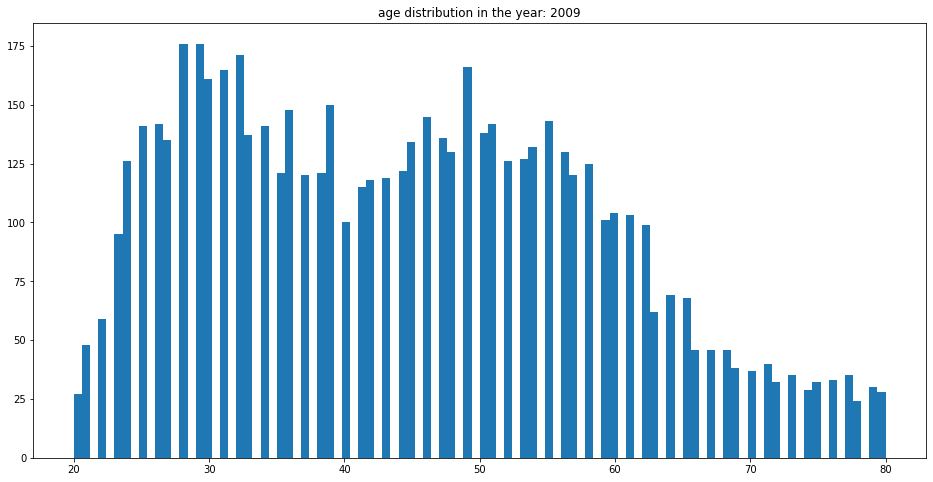

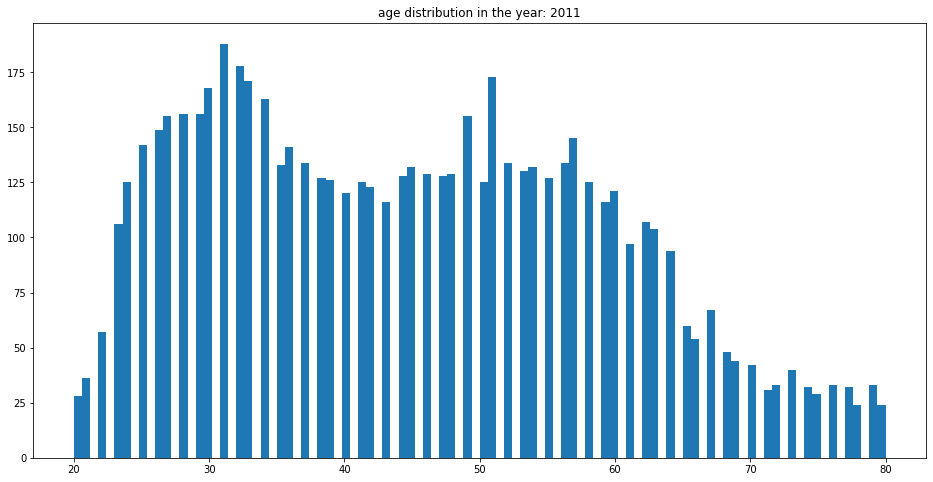

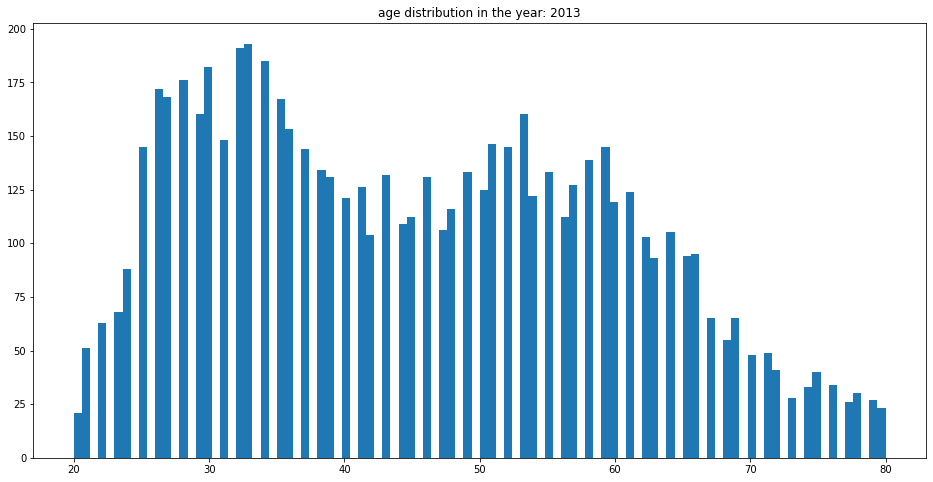

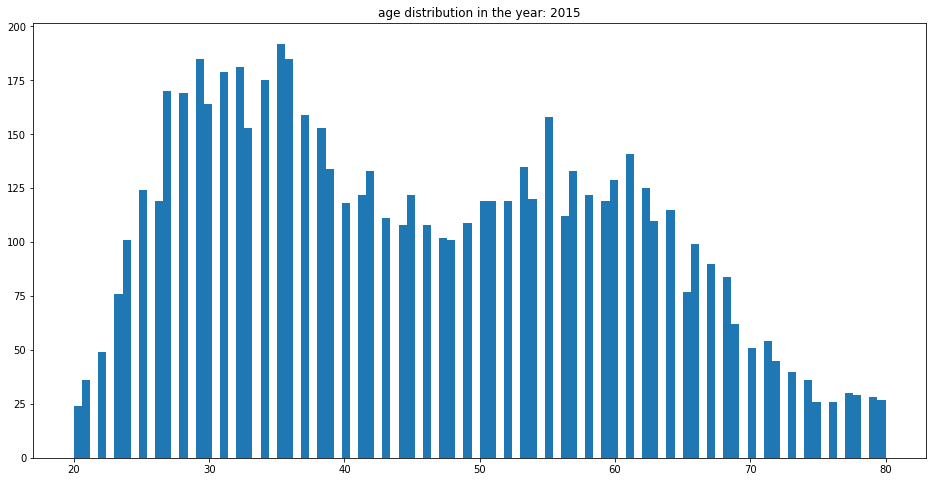

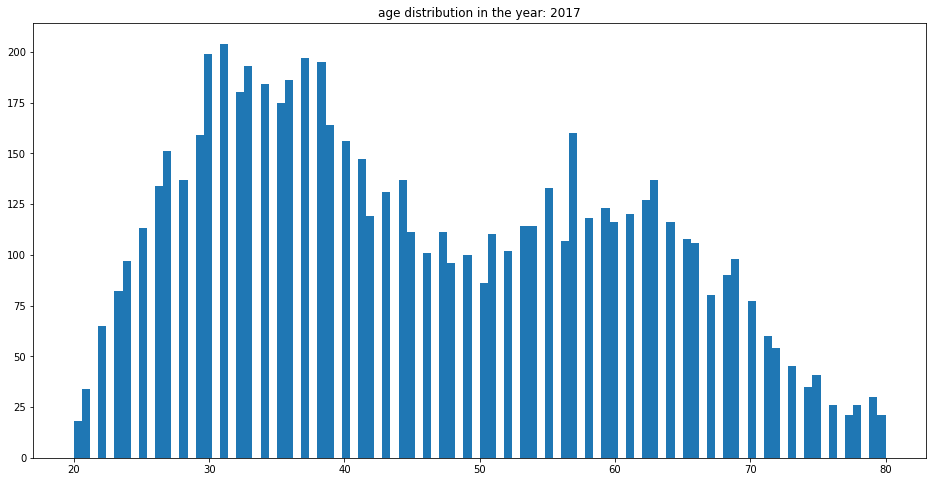

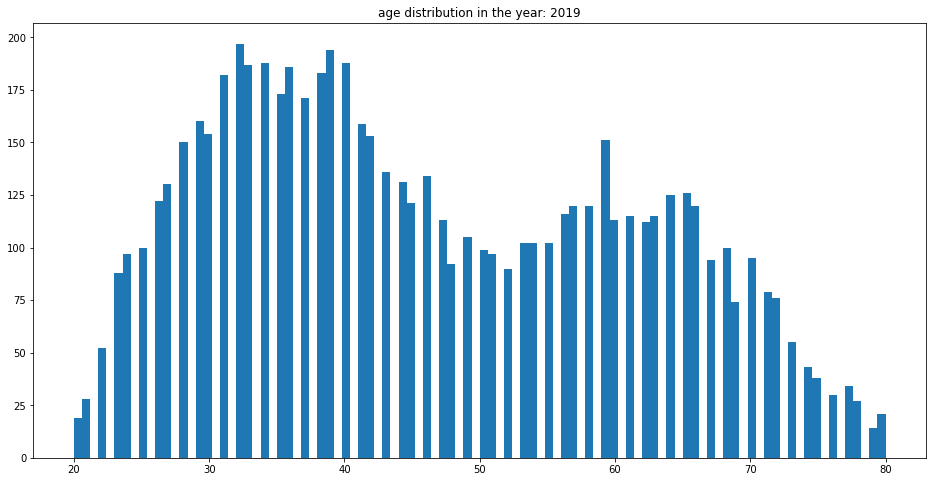

In [70]:
for year in years:
    plt.figure()
    plt.title("age distribution in the year: " + str(year))
    plt.hist(Fdf[Fdf["year"] == year].ageHead, bins = 100)

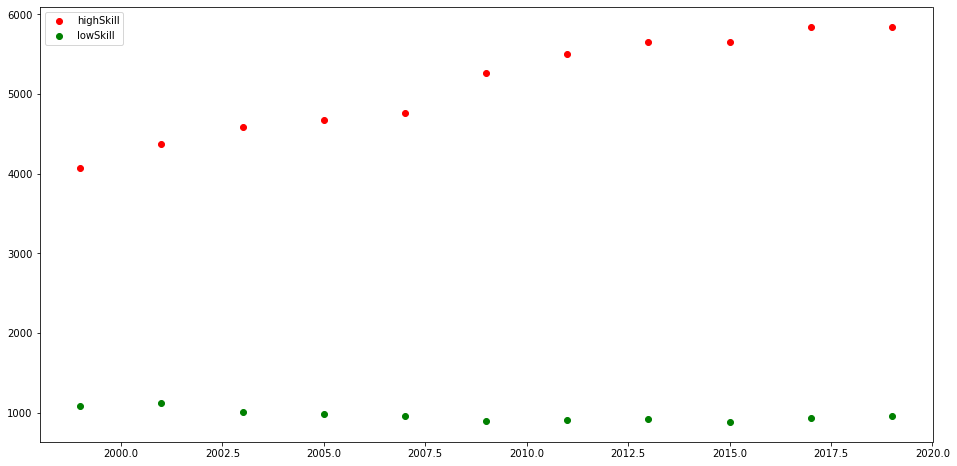

In [132]:
for year in years:
    highSkill = plt.scatter(year, Fdf[(Fdf["year"] == year)&(Fdf["skillLevel"] == "High")].shape[0], color = 'r')
    lowSkill = plt.scatter(year, Fdf[(Fdf["year"] == year)&(Fdf["skillLevel"] == "Low")].shape[0], color = 'g')
plt.legend((highSkill,lowSkill), ("highSkill", "lowSkill"))

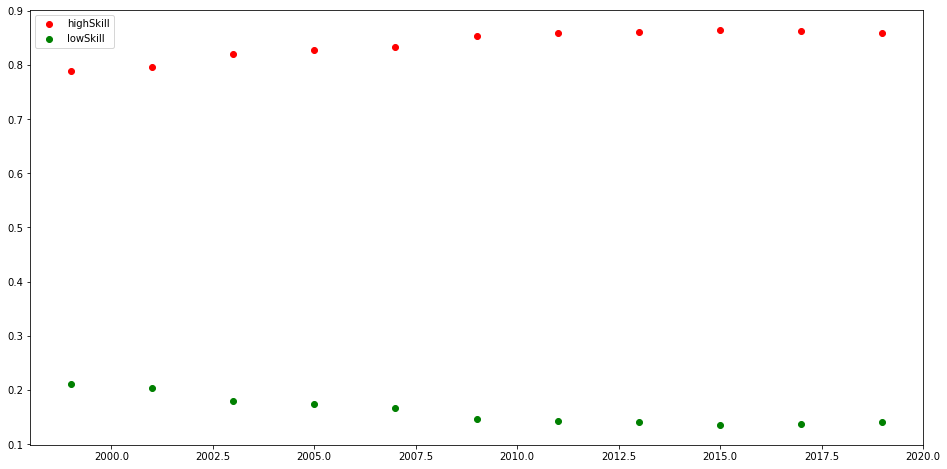

In [133]:
highSkillRatios = []
lowSkillRatios = []
for year in years:
    highRatio = Fdf[(Fdf["year"] == year)&(Fdf["skillLevel"] == "High")].shape[0]/Fdf[(Fdf["year"] == year)].shape[0]
    lowRatio = Fdf[(Fdf["year"] == year)&(Fdf["skillLevel"] == "Low")].shape[0]/Fdf[(Fdf["year"] == year)].shape[0]
    highSkillRatios.append(highRatio)
    lowSkillRatios.append(lowRatio)
    highSkill = plt.scatter(year, highRatio, color = 'r')
    lowSkill = plt.scatter(year, lowRatio, color = 'g')
plt.legend((highSkill,lowSkill), ("highSkill", "lowSkill"))

In [134]:
highSkillRatios

[0.7887897595034911,
 0.7957772115034584,
 0.8200821868858317,
 0.8267869780608634,
 0.8331003145753233,
 0.8540145985401459,
 0.8581228562519488,
 0.8598997112900775,
 0.8648731274839498,
 0.8626235797550539,
 0.8590761988820241]

In [135]:
lowSkillRatios

[0.2112102404965089,
 0.20422278849654169,
 0.1799178131141683,
 0.1732130219391366,
 0.16689968542467667,
 0.145985401459854,
 0.14187714374805113,
 0.1401002887099225,
 0.13512687251605013,
 0.13737642024494615,
 0.14092380111797587]

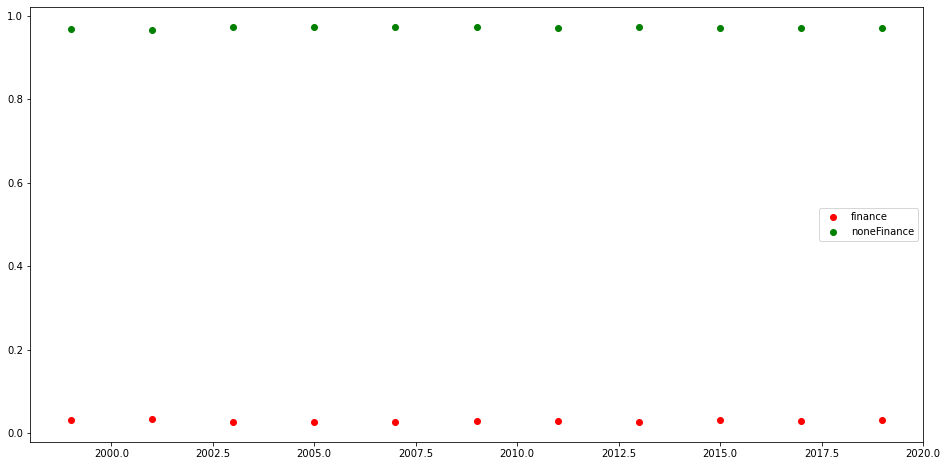

In [138]:
financeRatios = []
noneFinanceRatios= []
for year in years:
    fRatio = Fdf[(Fdf["year"] == year)&(Fdf["financeExperience"] == "Yes")].shape[0]/Fdf[(Fdf["year"] == year)].shape[0]
    nfRatio =  Fdf[(Fdf["year"] == year)&(Fdf["financeExperience"] == "No")].shape[0]/Fdf[(Fdf["year"] == year)].shape[0]
    financeRatios.append(fRatio)
    noneFinanceRatios.append(nfRatio)
    finance = plt.scatter(year, fRatio, color = 'r')
    noneFinance = plt.scatter(year, nfRatio, color = 'g')
plt.legend((finance,noneFinance), ("finance", "noneFinance"))

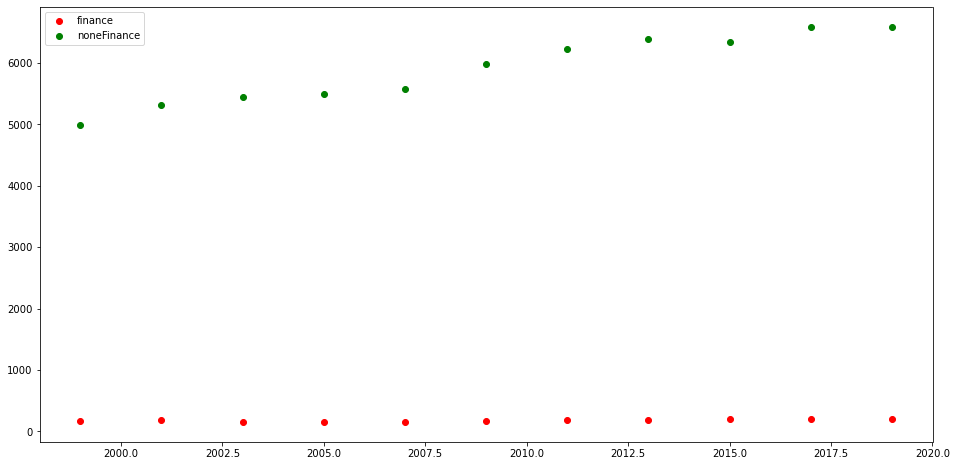

In [139]:
for year in years:
    finance = plt.scatter(year, Fdf[(Fdf["year"] == year)&(Fdf["financeExperience"] == "Yes")].shape[0], color = 'r')
    nonFinance = plt.scatter(year, Fdf[(Fdf["year"] == year)&(Fdf["financeExperience"] == "No")].shape[0], color = 'g')
plt.legend((finance,noneFinance), ("finance", "noneFinance"))

In [140]:
financeRatios

[0.03200155159038014,
 0.03330906443392792,
 0.027693407182419152,
 0.027423920736022647,
 0.026564138413142258,
 0.028223844282238442,
 0.02853133769878391,
 0.02780732411487616,
 0.030724549067563438,
 0.02862623579755054,
 0.030303030303030304]

In [141]:
noneFinanceRatios

[0.9679984484096199,
 0.9666909355660721,
 0.9723065928175808,
 0.9725760792639774,
 0.9734358615868577,
 0.9717761557177615,
 0.9714686623012161,
 0.9721926758851238,
 0.9692754509324366,
 0.9713737642024495,
 0.9696969696969697]

### empirical classes (richHigh, richLow, poorHigh, poorLow)

In [ ]:
richHighRatios = []
richLowRatios = []
poorHighRatios = []
poorLowRatios = []
for year in years:
    richLow = Fdf[(Fdf["year"] == year)&(Fdf["financeExperience"] == "Yes")&(Fdf["skillLevel"] == "High")].shape[0]/Fdf[(Fdf["year"] == year)].shape[0]
    richHigh =  Fdf[(Fdf["year"] == year)&(Fdf["financeExperience"] == "No")&(Fdf["skillLevel"] == "High")].shape[0]/Fdf[(Fdf["year"] == year)].shape[0]
    poorLow = Fdf[(Fdf["year"] == year)&(Fdf["financeExperience"] == "Yes")&(Fdf["skillLevel"] == "Low")].shape[0]/Fdf[(Fdf["year"] == year)].shape[0]
    poorHigh =  Fdf[(Fdf["year"] == year)&(Fdf["financeExperience"] == "No")&(Fdf["skillLevel"] == "Low")].shape[0]/Fdf[(Fdf["year"] == year)].shape[0]   
    richHighRatios.append(richHigh)
    richLowRatios.append(richLow)
    poorHighRatios.append(poorHigh)
    poorLowRatios.append(poorLow)
    rl = plt.scatter(year, richLow, color = "r")
    rh = plt.scatter(year, richHigh, color = "b")
    pl = plt.scatter(year, poorLow, color = "g")
    ph = plt.scatter(year, poorHigh, color = "k")
plt.legend((rl,rh,pl,ph), ("richLow", "richHigh", "poorLow", "poorHigh"))

### simulation based on the real data

In [72]:
Fdf.head()

,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,participation,...,employmentStatus,education,race,industry,ownership,skillLevel,financeExperience,ageGroup,decadeGroup,stockInvestmentRatio
0,3,1999,2,1,76,2.35,0.00,7.30,7.30,0,...,retired,highSchool,White,noneFinance,owner,Low,No,60-80,1990s,0.00
1,2,1999,0,4,47,0.00,26.14,4.17,16.68,1,...,employed,highSchool,White,noneFinance,owner,Low,No,40-60,1990s,0.40
2,6129,1999,3,1,45,8.81,0.00,16.70,16.70,1,...,employed,college,White,finance,owner,High,Yes,40-60,1990s,0.02
3,6944,1999,0,2,39,14.09,35.23,10.29,20.58,0,...,employed,college,White,noneFinance,owner,High,No,20-40,1990s,0.00
4,3818,1999,4,4,34,0.00,48.85,4.45,17.80,0,...,employed,highSchool,White,noneFinance,owner,Low,No,20-40,1990s,0.00


In [131]:
years

[1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019]

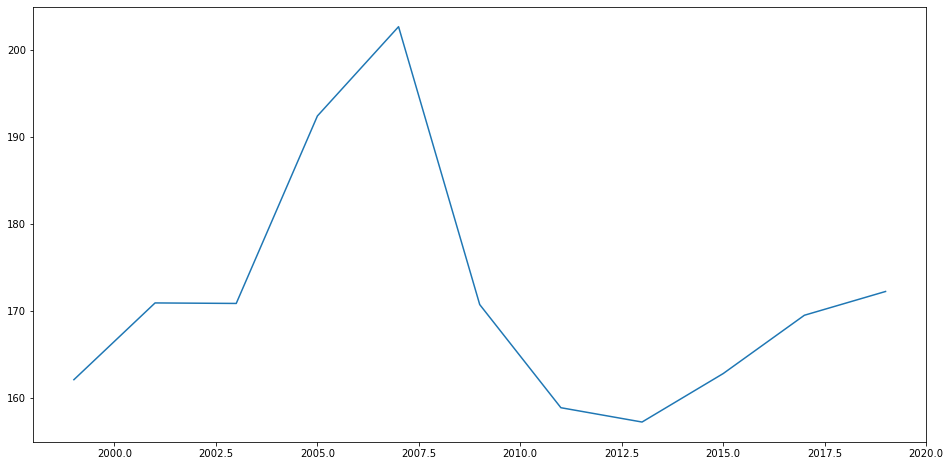

In [130]:
wealthLevel = []
for year in years:
    wealthLevel.append(Fdf[(Fdf['year'] == year)]["wealthWithHomeEquity"].mean())
plt.plot(years,wealthLevel)

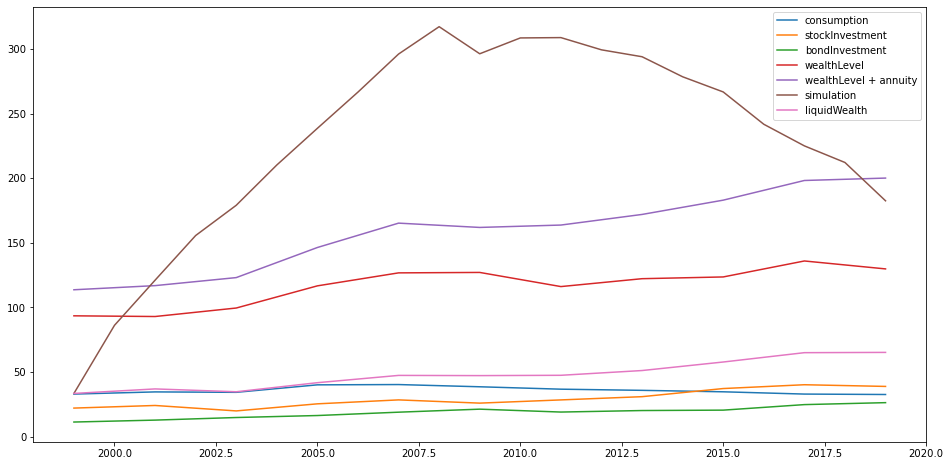

In [261]:
wealthLevel = []
consumption = []
investmentStock = []
bondOrcash = []
annuityAmount = []
for year in years:
    wealthLevel.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["wealthWithoutHomeEquity"].mean())
    investmentStock.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["investmentAmount"].mean())
    consumption.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["totalExpense"].mean())
    bondOrcash.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["liquidWealth"].mean())
    annuityAmount.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["annuityIRA"].mean())

plt.plot(years,consumption, label = "consumption")
plt.plot(years,investmentStock, label = "stockInvestment")
plt.plot(years,bondOrcash, label = "bondInvestment")
plt.plot(years,np.array(wealthLevel) - np.array(annuityAmount), label = "wealthLevel")
plt.plot(years,np.array(wealthLevel), label = "wealthLevel + annuity")
plt.plot(range(1999,2020), wwww.mean(axis = 1), label = "simulation")
plt.plot(years,np.array(investmentStock) + np.array(bondOrcash), label = "liquidWealth")
plt.legend()

In [272]:
wwww.shape

(21, 35640)

In [275]:
2019-1999

20

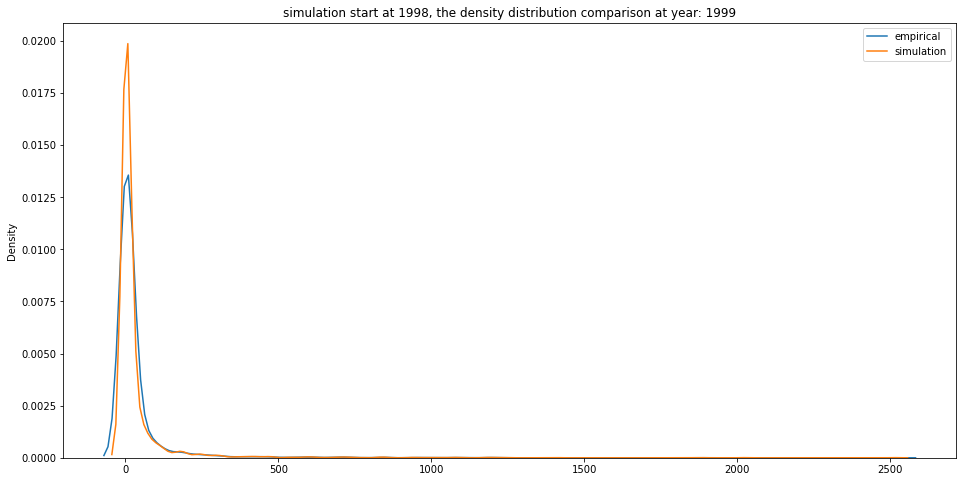

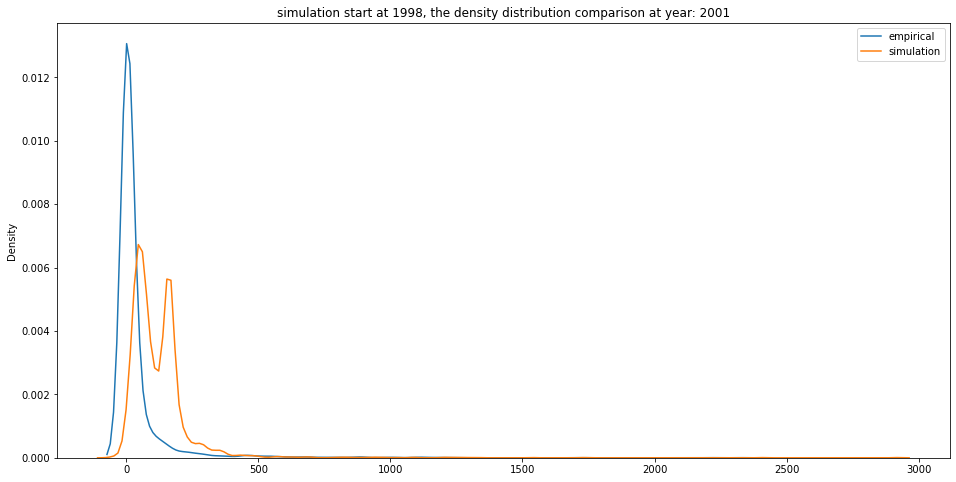

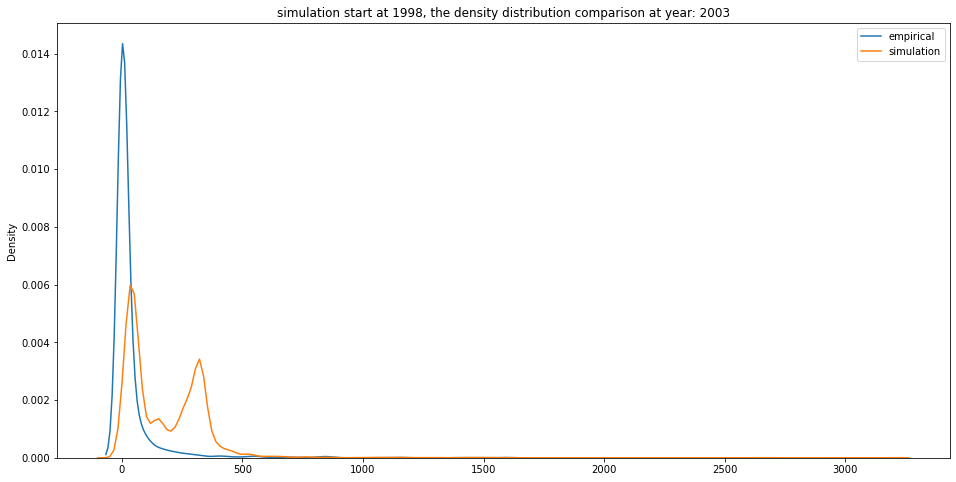

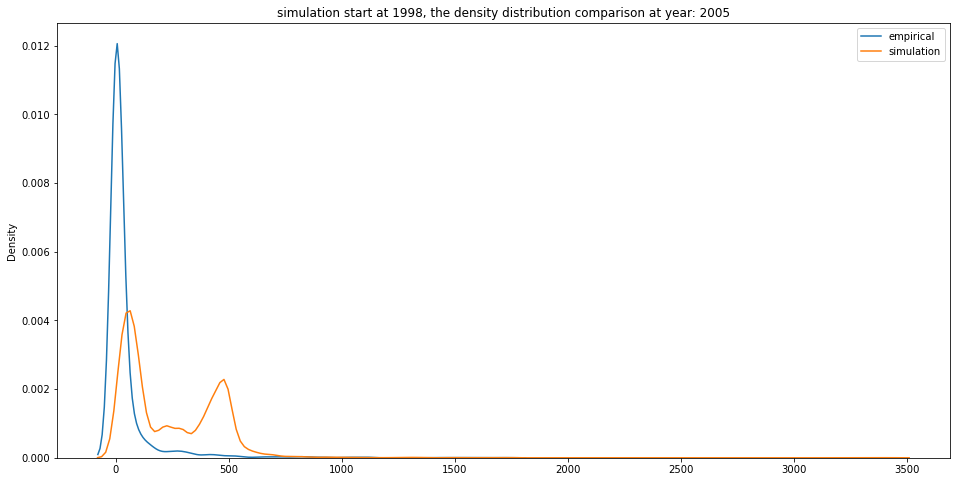

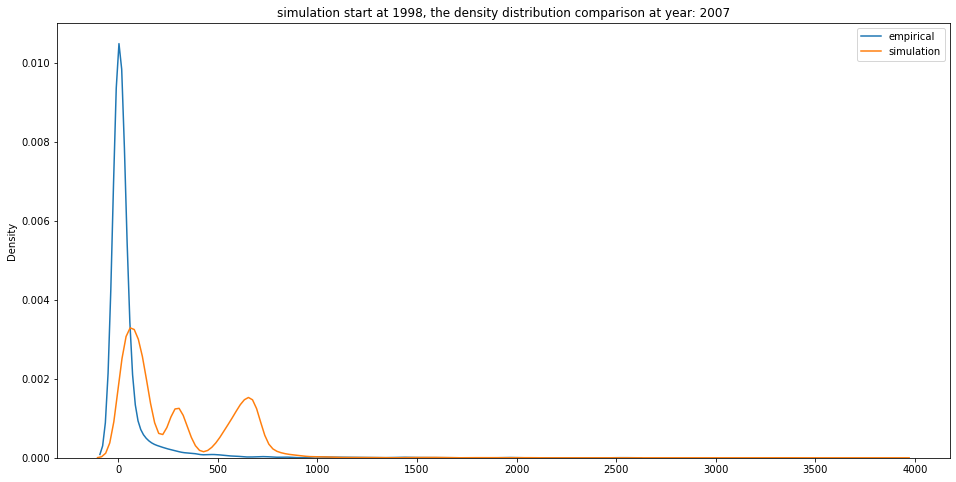

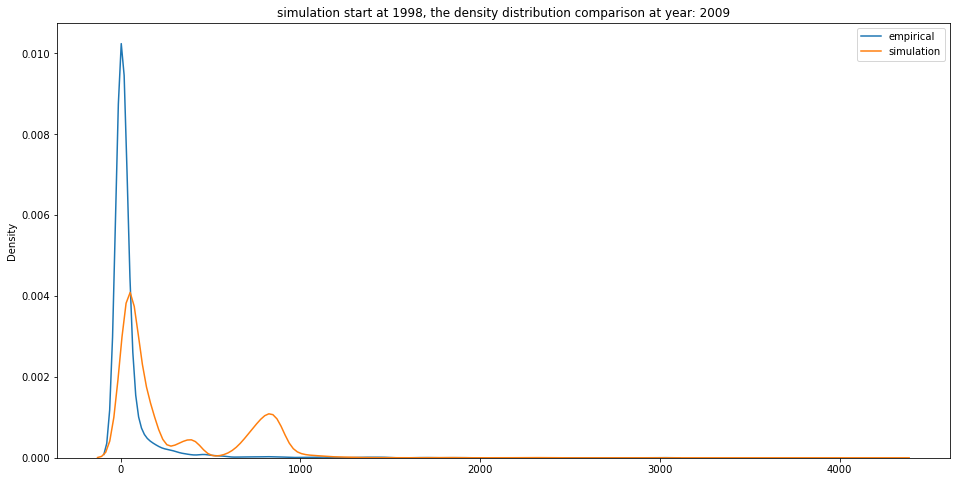

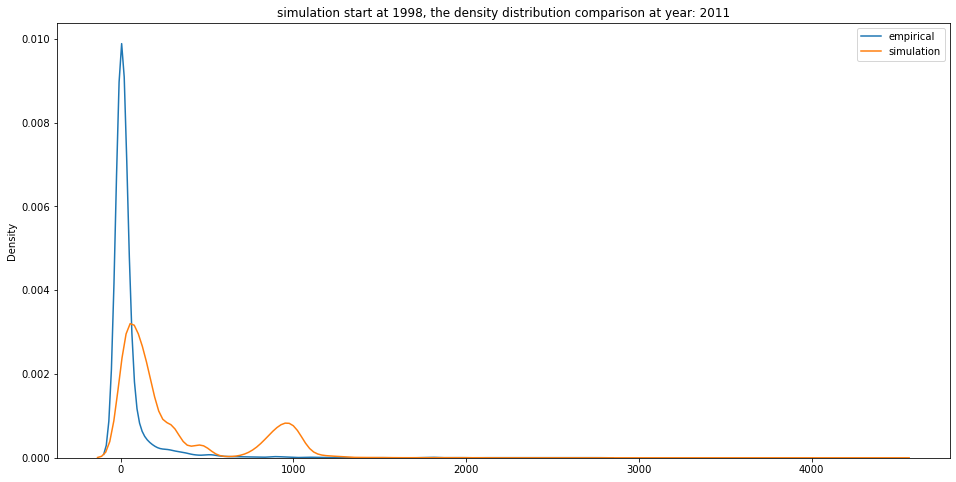

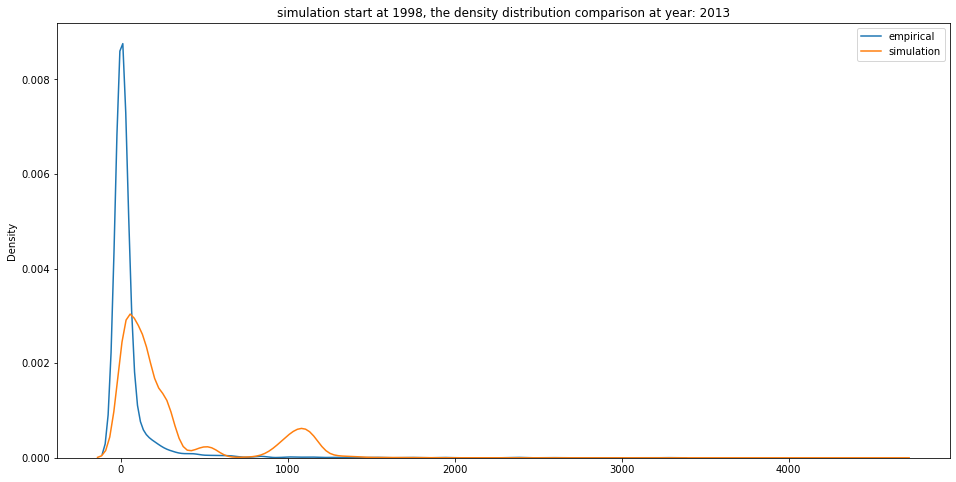

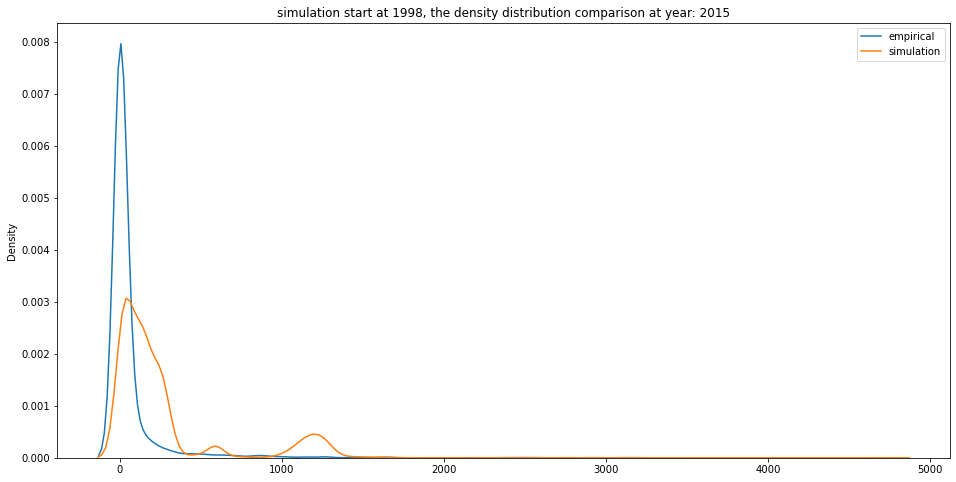

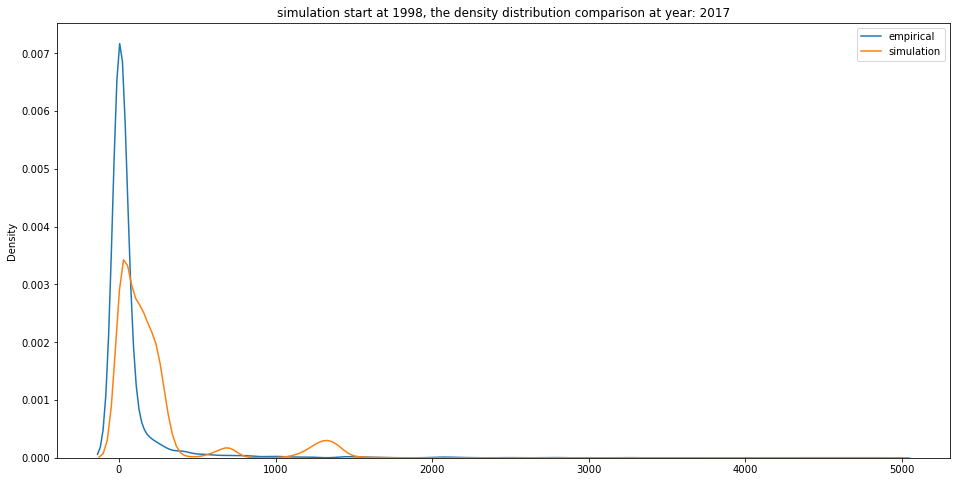

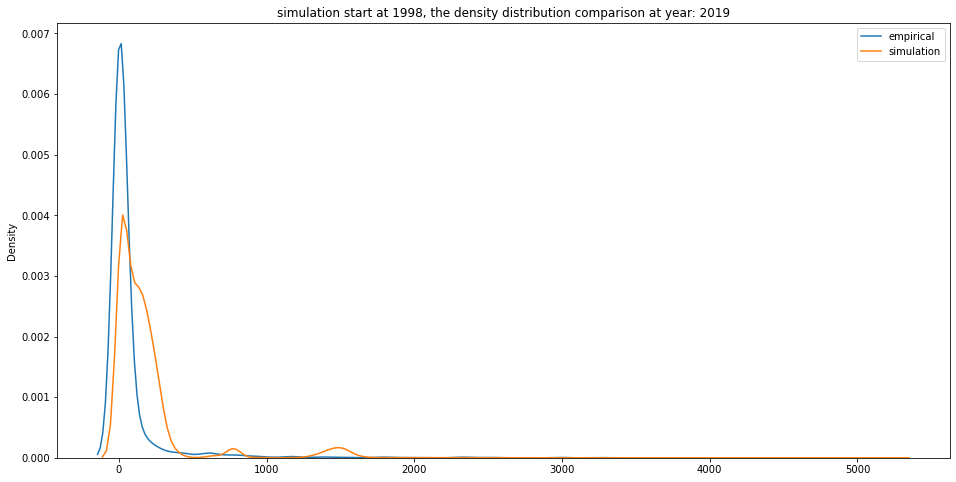

In [295]:
import seaborn as sns

for year in years:  
    bond = Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["liquidWealth"].values
    stock = Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["investmentAmount"].values
    wealthAmount = bond + stock
    simulatedWealthAmount = wwww[year - 1999,:]
    plt.figure()
    plt.title("simulation start at 1998, the density distribution comparison at year: "+str(year))
    sns.kdeplot(wealthAmount,label = "empirical")
    sns.kdeplot(simulatedWealthAmount, label = "simulation")
    plt.legend()
    plt.savefig("densityComparison" + str(year) + ".png")

In [250]:
wwww[-1,:].mean()

182.4712

In [254]:
www.mean()

65.19559334565538

In [252]:
year = 2019
df_2019 = Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]

In [253]:
www = df_2019.liquidWealth + df_2019.investmentAmount
www.mean()

65.19559334565538

In [255]:
www.std()

234.01275005808336

In [256]:
wwww.std()

303.52145

In [226]:
w1 = np.load("../w1.npy")
w2 = np.load("../w2.npy")
w3 = np.load("../w3.npy")
w4 = np.load("../w4.npy")

In [227]:
wwww = np.concatenate((w1,w2,w3,w4), axis = 1)

In [222]:
wwww.mean(axis = 1)

array([ 33.441097,  85.3948  , 120.44479 ], dtype=float32)

In [122]:
empiricalEcon = pd.read_csv('../constant/empiricalEcon.csv',delimiter=',')
empiricalEcon = empiricalEcon.set_index("year")
empiricalEcon = empiricalEcon/100

<AxesSubplot:xlabel='year'>

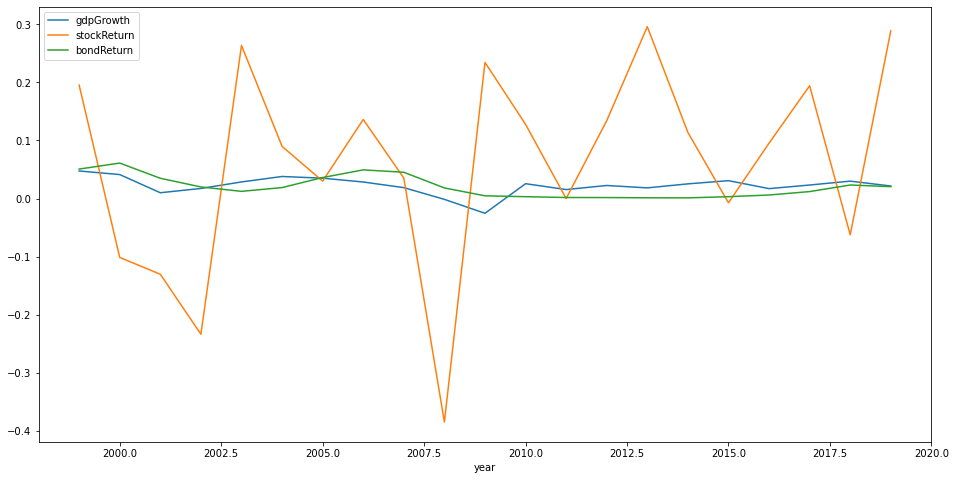

In [127]:
empiricalEcon[(empiricalEcon.index >= 1999) & (empiricalEcon.index <= 2019)].plot()

In [150]:
Fdf.columns

Index(['familyID', 'year', 'composition', 'headCount', 'ageHead',
       'liquidWealth', 'laborIncome', 'costPerPerson', 'totalExpense',
       'participation', 'investmentAmount', 'annuityIRA',
       'wealthWithoutHomeEquity', 'wealthWithHomeEquity', 'HomeEquity',
       'maritalStatus', 'employmentStatus', 'education', 'race', 'industry',
       'ownership', 'skillLevel', 'financeExperience', 'ageGroup',
       'decadeGroup', 'stockInvestmentRatio'],
      dtype='object')

In [169]:
# what do we need for simulation? 
# [w,ab,s,e,o,z]
Fdf[(Fdf['year'] == 1999) & (Fdf['ageHead'] >= 30) & (Fdf['ageHead'] <= 60)]

,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,participation,...,employmentStatus,education,race,industry,ownership,skillLevel,financeExperience,ageGroup,decadeGroup,stockInvestmentRatio
1,2,1999,0,4,47,0.00,26.14,4.17,16.68,1,...,employed,highSchool,White,noneFinance,owner,Low,No,40-60,1990s,0.40
2,6129,1999,3,1,45,8.81,0.00,16.70,16.70,1,...,employed,college,White,finance,owner,High,Yes,40-60,1990s,0.02
3,6944,1999,0,2,39,14.09,35.23,10.29,20.58,0,...,employed,college,White,noneFinance,owner,High,No,20-40,1990s,0.00
4,3818,1999,4,4,34,0.00,48.85,4.45,17.80,0,...,employed,highSchool,White,noneFinance,owner,Low,No,20-40,1990s,0.00
7,2122,1999,2,1,50,7.05,58.71,29.29,29.29,1,...,employed,postGraduate,White,noneFinance,owner,High,No,40-60,1990s,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5334,6687,1999,0,4,36,0.00,0.00,1.89,7.56,0,...,unemployed,highSchool,Latino,noneFinance,renter,Low,No,20-40,1990s,0.00
5336,4011,1999,1,2,45,0.00,5.87,6.14,12.28,0,...,employed,college,Black,noneFinance,owner,High,No,40-60,1990s,0.00
5338,1242,1999,1,4,48,7.05,55.19,7.34,29.36,0,...,employed,college,Black,noneFinance,renter,High,No,40-60,1990s,0.00
5340,625,1999,0,4,41,14.09,112.73,10.29,41.17,0,...,employed,postGraduate,Black,noneFinance,owner,High,No,40-60,1990s,0.00


In [175]:
df_1999_30to60 = Fdf[(Fdf['year'] == 1999) & (Fdf['ageHead'] >= 30) & (Fdf['ageHead'] <= 60)]
df_1999_30to60

,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,participation,...,employmentStatus,education,race,industry,ownership,skillLevel,financeExperience,ageGroup,decadeGroup,stockInvestmentRatio
1,2,1999,0,4,47,0.00,26.14,4.17,16.68,1,...,employed,highSchool,White,noneFinance,owner,Low,No,40-60,1990s,0.40
2,6129,1999,3,1,45,8.81,0.00,16.70,16.70,1,...,employed,college,White,finance,owner,High,Yes,40-60,1990s,0.02
3,6944,1999,0,2,39,14.09,35.23,10.29,20.58,0,...,employed,college,White,noneFinance,owner,High,No,20-40,1990s,0.00
4,3818,1999,4,4,34,0.00,48.85,4.45,17.80,0,...,employed,highSchool,White,noneFinance,owner,Low,No,20-40,1990s,0.00
7,2122,1999,2,1,50,7.05,58.71,29.29,29.29,1,...,employed,postGraduate,White,noneFinance,owner,High,No,40-60,1990s,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5334,6687,1999,0,4,36,0.00,0.00,1.89,7.56,0,...,unemployed,highSchool,Latino,noneFinance,renter,Low,No,20-40,1990s,0.00
5336,4011,1999,1,2,45,0.00,5.87,6.14,12.28,0,...,employed,college,Black,noneFinance,owner,High,No,40-60,1990s,0.00
5338,1242,1999,1,4,48,7.05,55.19,7.34,29.36,0,...,employed,college,Black,noneFinance,renter,High,No,40-60,1990s,0.00
5340,625,1999,0,4,41,14.09,112.73,10.29,41.17,0,...,employed,postGraduate,Black,noneFinance,owner,High,No,40-60,1990s,0.00


In [178]:
# [w,ab,s,e,o,z]
# w explicitly 
# assume ab = 30 the strong assumption we made 
# s is known 
# e is known 
# o is known
# z is known
df_1999_30to60.to_csv("../df_1999_30to60.csv")

In [179]:
df_1999_30to60.columns

Index(['familyID', 'year', 'composition', 'headCount', 'ageHead',
       'liquidWealth', 'laborIncome', 'costPerPerson', 'totalExpense',
       'participation', 'investmentAmount', 'annuityIRA',
       'wealthWithoutHomeEquity', 'wealthWithHomeEquity', 'HomeEquity',
       'maritalStatus', 'employmentStatus', 'education', 'race', 'industry',
       'ownership', 'skillLevel', 'financeExperience', 'ageGroup',
       'decadeGroup', 'stockInvestmentRatio'],
      dtype='object')